In [2]:
import wget
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm

from tcn import TCN

data = loadmat('MotorDataSet.mat')
array_data = data['Motordata']

print('Original vector length: ',len(array_data[:,0]), 'samples')

from itertools import islice
def downsample_to_proportion(rows, proportion=1):
    return list(islice(rows, 0, len(rows), int(1/proportion)))

# data shape:    [Wref Wmeas Idref Iqref Idmeas Iqmeas Vd Vq] 
Wref = downsample_to_proportion(array_data[1500000:2000000,0], 0.2)
Wmeas = downsample_to_proportion(array_data[1500000:2000000,1], 0.2)
Idref = downsample_to_proportion(array_data[1500000:2000000,2], 0.2)
Iqref = downsample_to_proportion(array_data[1500000:2000000,3], 0.2)
Idmeas = downsample_to_proportion(array_data[1500000:2000000,4], 0.2)
Iqmeas = downsample_to_proportion(array_data[1500000:2000000,5], 0.2)
Vd = downsample_to_proportion(array_data[1500000:2000000,6], 0.2)
Vq = downsample_to_proportion(array_data[1500000:2000000,7], 0.2)

print('Down-sampled vector length: ',len(Wmeas), 'samples')

# Error signals (input of the PID)
Speed_error = np.subtract(Wref, Wmeas) 
in_loop_q = np.subtract(Iqref, Iqmeas) 
in_loop_d = np.subtract(Idref, Idmeas) 


# Speed NN (outter loop)
#Input (Speed reference and error)
    #plt.plot(Speed_error)
    #plt.plot(Wref)
#Output (Iq reference)
    #plt.plot(Iqref)

# Organize input and output of NN
in2 = [in_loop_q, in_loop_d, Wref]
in2 = np.asarray(in2)
in2 = np.transpose(in2)

out2 = [Vd, Vq]
out2 = np.asarray(out2)
out2 = np.transpose(out2)    

print('Input shape:', in2.shape)
print('Output shape:', out2.shape)

x = in2
y = out2

Original vector length:  2865008 samples
Down-sampled vector length:  100000 samples
Input shape: (100000, 3)
Output shape: (100000, 2)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle= True)

In [5]:
model = Sequential()

model.add(Dense(64, input_dim = 3, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(2,  activation = 'linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,402
Trainable params: 2,402
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(x_train, y_train, validation_split= 0.2, epochs = 50)

Epoch 1/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 7.1315e-04 - val_mse: 7.1315e-04
Epoch 2/50
2000/2000 [==============================] - 3s 2ms/step - loss: 7.3671e-04 - mse: 7.3671e-04 - val_loss: 7.1175e-04 - val_mse: 7.1175e-04
Epoch 3/50
2000/2000 [==============================] - 3s 2ms/step - loss: 6.7034e-04 - mse: 6.7034e-04 - val_loss: 5.6624e-04 - val_mse: 5.6624e-04
Epoch 4/50
2000/2000 [==============================] - 3s 2ms/step - loss: 5.4082e-04 - mse: 5.4082e-04 - val_loss: 6.9413e-04 - val_mse: 6.9413e-04
Epoch 5/50
2000/2000 [==============================] - 3s 2ms/step - loss: 4.1646e-04 - mse: 4.1646e-04 - val_loss: 4.2728e-04 - val_mse: 4.2728e-04
Epoch 6/50
2000/2000 [==============================] - 3s 2ms/step - loss: 3.8045e-04 - mse: 3.8045e-04 - val_loss: 3.5269e-04 - val_mse: 3.5269e-04
Epoch 7/50
2000/2000 [==============================] - 4s 2ms/step - loss: 3.7645e-04 - mse: 3.7645e-04 - v

In [ ]:
#model.save('Regressor_torque.h5')

In [7]:
score = model.evaluate(x_test, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 2.9824e-04 - mse: 2.9824e-04


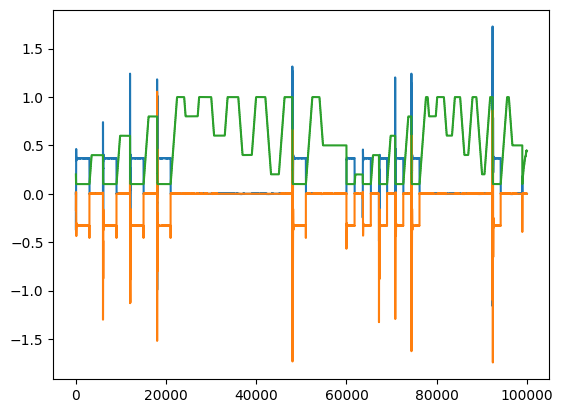

In [18]:
plt.plot(x)

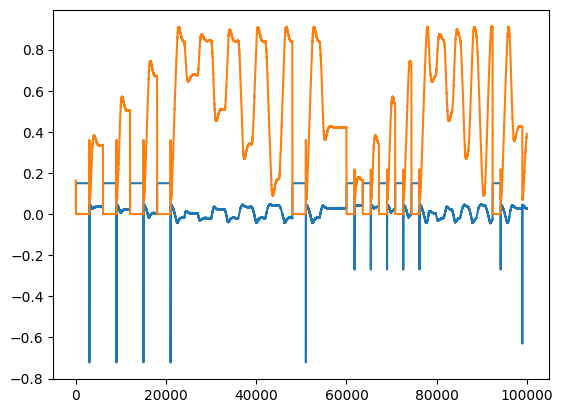

In [17]:
plt.plot(y)

625/625 [==============================] - 1s 2ms/step


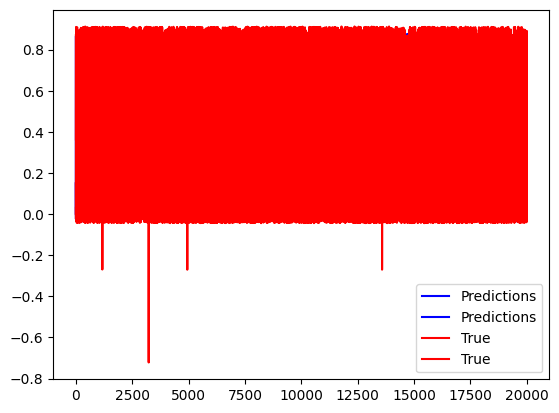

In [20]:
predictions = model.predict(x_test)

plt.plot(predictions, label='Predictions', color='blue')
plt.plot(y_test, label='True', color='red')
plt.legend()


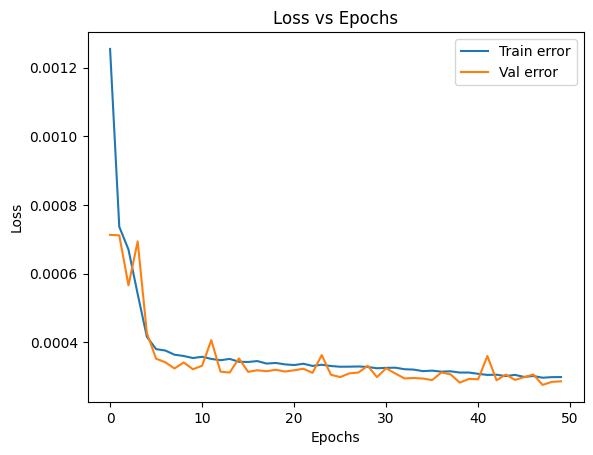

In [9]:
def plot_history(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.plot(hist['epoch'], hist['loss'],label = 'Train error')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val error')
    plt.legend()

plot_history(history)

In [ ]:
# Early stopping
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode='min', patience=50)
model2 = build_model()
history = model2.fit(x_train, y_train, validation_split= 0.2, epochs = 50, callbacks=[es])
plot_history(history)
score = model2.evaluate(x_test, y_test)

In [ ]:
# Sliding window

def sliding_window(train, window_size=2, horizon=1):
    '''sliding window
    parameters: 
    train: array-like (training data for time series method)
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include
        
    horizon: int, optional (default = 1)
        number of observations ahead to predict
        
    Returns: array-like, array-like
            preprocessed X, preprocessed Y  '''

    tabular_X = []
    tabular_Y = []

    for i in range (0, len(train) - window_size - horizon):
        x_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(x_train)
        tabular_Y.append(y_train)
    
    return np.asarray(tabular_X), np.asarray(tabular_Y).reshape(-1,)

In [ ]:
# Preprocess time series training and test sets
x_train, y_train = sliding_window(tsdata, window_size=2)

training_length = int(len(y_train) * 2/3)

x_train, x_test = x_train[:training_length], x_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]
print(x_train.shape, y_train.shape)